Загрузим исходное изображение

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import time
import cv2
import warnings
warnings.filterwarnings("ignore")

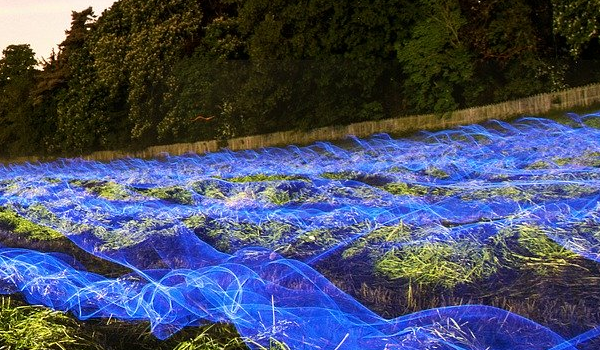

In [3]:
img = np.array(Image.open('/content/gdrive/My Drive/ABBYY Homeworks/Original.bmp'))
Image.fromarray(img[650:1000, 1250:1850, :])

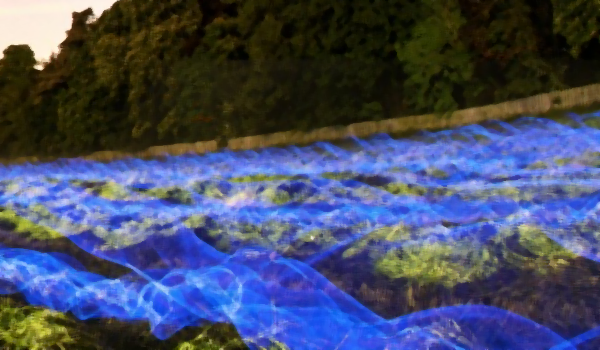

In [4]:
Image.fromarray(cv2.medianBlur(img[650:1000, 1250:1850, :], 5))

In [5]:
img.shape

(1280, 1920, 3)

# Простая сортировка

Данный алгоритм для нахождения медианы сортирует пиксели в каждом окне размером $2R+1$ на $2R + 1$ это занимает порядка $O(R^2\log R)$ в случае использования сортировки слиянием или другой сортировки, которая работает за $O(R\log R)$. Помимо хранения изображения отводится $O(R^2)$ памяти для хранения пикселей в окне

In [33]:
class NaiveMedianFilter:
  def __init__(self, path_to_original_img):

    self.path_to_original_img = path_to_original_img
    self.original_img = Image.open(path_to_original_img)

    self.result_img = None
    self.time_of_exec = None

  def show_img(self, path):
    if 'original' in path.lower(): 
      plt.imshow(self.original_img)
      plt.show()
    elif 'result' in path.lower():
      plt.imshow(self.result_img)
      plt.show()
    else:
      print('Nothing to show')

  def compute_res_img(self, R : int, img = None, calculation_time = False):
    if img is None:
      img = np.array(self.original_img)

    if calculation_time:
      start = time.time()

    h, w, c = img.shape
    result = np.zeros(img.shape)
    padded = self.pad(img, R)
    median_idx = (2 * R + 1) ** 2 // 2
    for i in range(0, h):
        for j in range(0, w):
            result[i][j] = np.sort(padded[i:i + 2*R + 1, j :j + 2*R + 1]
                                           .reshape(-1,c), axis=0)[median_idx]
    self.result_img = result

    if calculation_time:
      end = time.time()

    self.time_of_exec = (end-start) * 10**3/img.shape[0]/img.shape[1]

  def pad(self, img, R):
    return cv2.copyMakeBorder(img, R, R, R, R, cv2.BORDER_REPLICATE)


In [ ]:
filter_1 = NaiveMedianFilter('/content/gdrive/My Drive/ABBYY Homeworks/Original.bmp')
filter_1.compute_res_img(6)

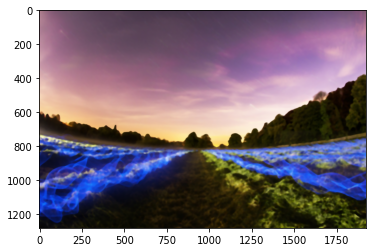

In [ ]:
filter_1.show_img('result')

# Алгоритм Huang et al.

При движении окна вдоль строки требуется порядка $O(R)$ операции на пиксель при движении гистограммы. Удаляется старый столбец и добавляется новый длиной $2R+1$. Также требуется $O(N)$ операций на обновление медианы (N - число уровней квантования). В итоге данный алгоритм имеет временную сложность $O(R+N)$. На хранение гистограммы отводится $O(N)$ дополнительной памяти, то есть данный алгоритм линеен по времени и по памяти.


In [30]:
class Hist:
    def __init__(self, window):
        self.R2p1 = window.shape[0]
        self.R = self.R2p1 // 2
        self.mdn_idx = self.R2p1 ** 2 // 2
        self.hist = np.zeros(256)
        
        for i in range(self.R2p1):
            for j in range(self.R2p1):
                self.hist[window[i][j]] += 1
                
        self.lt_mdn = 0
        self.mdn = 0
        self.upd_mdn()        
    
    def move_window(self, lmp_column: np.array, rm_column: np.array):
        for x in lmp_column:
            self.hist[x] -= 1
        for x in rm_column:
            self.hist[x] += 1
        self.lt_mdn += (rm_column < self.mdn).sum() - (lmp_column < self.mdn).sum()
        self.upd_mdn()
                
    def upd_mdn(self):
        if self.lt_mdn <= self.mdn_idx:
            while self.lt_mdn + self.hist[self.mdn] <= self.mdn_idx:
                self.lt_mdn += self.hist[self.mdn]
                self.mdn += 1
        else:        
            while self.lt_mdn > self.mdn_idx:
                self.mdn -= 1
                self.lt_mdn -= self.hist[self.mdn]
                
    def get_mdn(self):
        return self.mdn  

In [34]:
class HuangFilter:
  def __init__(self, path_to_original_img):

    self.path_to_original_img = path_to_original_img
    self.original_img = Image.open(path_to_original_img)

    self.result_img = None
    self.time_of_exec = None

  def show_img(self, path):
    if 'original' in path.lower(): 
      plt.imshow(self.original_img)
      plt.show()
    elif 'result' in path.lower():
      plt.imshow(self.result_img)
      plt.show()
    else:
      print('Nothing to show')

  def compute_res_img(self, R : int, img = None, calculation_time = False):
    if img is None:
      img = np.array(self.original_img)

    if calculation_time:
      start = time.time()

    h, w, c = img.shape
    result = np.zeros_like(img)
    padded = self.pad(img, R)
    for k in range(c):
        for i in range(R, h + R):
            hist = Hist(padded[i - R:i + R + 1, :2 * R + 1, k])
            result[i - R][0][k] = hist.get_mdn()
            for j in range(R + 1, w + R):
                lmp_column = padded[i - R:i + R + 1,j - R - 1, k].reshape(-1)
                rm_column = padded[i - R:i + R + 1,j + R, k].reshape(-1)
                hist.move_window(lmp_column, rm_column)
                result[i - R][j - R][k] = hist.get_mdn()

    self.result_img = result

    if calculation_time:
      end = time.time()

    self.time_of_exec = (end-start) * 10**3/img.shape[0]/img.shape[1]

  def pad(self, img, R):
  
    return cv2.copyMakeBorder(img, R, R, R, R, cv2.BORDER_REPLICATE)

In [ ]:
filter_2 = HuangFilter('/content/gdrive/My Drive/ABBYY Homeworks/Original.bmp')
filter_2.compute_res_img(6)

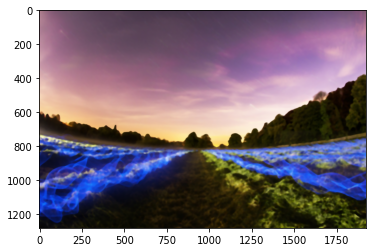

In [ ]:
filter_2.show_img('result')

# Более эффективная реализация за O(1)

При движении окна вдоль строки требуется $O(N)$ операций на пиксель для обновления гистограммы фильтра сложения с гистограммой столбца, который мы хотим добавить. Столько же операций идет на вычитание гистограммы удаляемого столбца. Для поиска медианы требуется также $O(N)$ операций. В общей сложности требуется $O(N)$ времени на работу алгоритма. Помимо хранения изображения требуется $O(L*N)$ дополнительной памяти на хранение гистограммы фильтра и гистограмм каждого из столбцов. В результате получаем, что алгоритм не зависит от параметра $R$, отвечающего для размер окна.


In [31]:
def build_hist(column):
    hist = np.zeros(256)
    for x in column:
        hist[x] += 1
    return hist

class Hists:
    def __init__(self, first_rows):
        self.R2p1 = first_rows.shape[0]
        self.R = self.R2p1 // 2
        self.mdn_idx = self.R2p1 ** 2 // 2
        
        self.hists = np.apply_along_axis(build_hist, 1, 
                        np.swapaxes(first_rows,0,1))
        self.init_H()
            
    def init_H(self):
        self.H = np.sum(self.hists[:self.R2p1], axis=0)
    
    def upd_column(self, j):
        lmp_hist = self.hists[j - self.R]
        rm_hist = self.hists[j + self.R + 1]
        self.H += rm_hist - lmp_hist
    
    def upd_row(self, ump_row, dm_row):
        for idx in range(self.hists.shape[0]):
            self.hists[idx][ump_row[idx]] -= 1
            self.hists[idx][dm_row[idx]] += 1
        self.init_H()
                
    def get_mdn(self):
        lt_mdn = 0
        mdn = 0
        if lt_mdn <= self.mdn_idx:
            while lt_mdn + self.H[mdn] <= self.mdn_idx:
                lt_mdn += self.H[mdn]
                mdn += 1
        else:        
            while lt_mdn > self.mdn_idx:
                mdn -= 1
                lt_mdn -= self.H[mdn]
        return mdn

In [35]:
class ConstFilter:
  def __init__(self, path_to_original_img):

    self.path_to_original_img = path_to_original_img
    self.original_img = Image.open(path_to_original_img)

    self.result_img = None
    self.time_of_exec = None

  def show_img(self, path):
    if 'original' in path.lower(): 
      plt.imshow(self.original_img)
      plt.show()
    elif 'result' in path.lower():
      plt.imshow(self.result_img)
      plt.show()
    else:
      print('Nothing to show')

  def compute_res_img(self, R : int, img = None, calculation_time = False):
    if img is None:
      img = np.array(self.original_img)

    if calculation_time:
      start = time.time()

    h, w, channels = img.shape
    result = np.zeros_like(img)
    padded = self.pad(img, R)
    for c in range(channels):
        padded_ch = padded[:,:,c]
        hists = Hists(padded_ch[:2 * R + 1,:])
        for i in range(R, h + R):
            for j in range(R, w + R):
                result[i - R][j - R][c] = hists.get_mdn()
                if j != w + R - 1:
                    hists.upd_column(j)
            if i != h + R - 1:
                ump_row = padded_ch[i - R,:]
                dm_row = padded_ch[i + R + 1,:]
                hists.upd_row(ump_row, dm_row)

    self.result_img = result

    if calculation_time:
      end = time.time()

    self.time_of_exec = (end-start) * 10**3/img.shape[0]/img.shape[1]

  def pad(self, img, R):
  
    return cv2.copyMakeBorder(img, R, R, R, R, cv2.BORDER_REPLICATE)

In [9]:
filter_3 = ConstFilter('/content/gdrive/My Drive/ABBYY Homeworks/Original.bmp')
filter_3.compute_res_img(6)

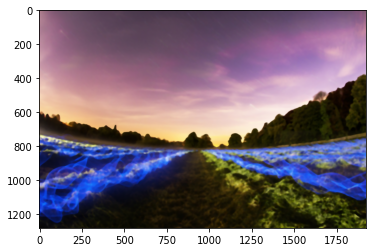

In [10]:
filter_3.show_img('result')

# Проверка корректности алгоритмов

In [28]:
window_sizes = [1,2,4,6,8,10]
path = '/content/gdrive/My Drive/ABBYY Homeworks/Original.bmp'
img_part = 100

naive_filter = NaiveMedianFilter(path)
huang_filter = HuangFilter(path)
const_filter = ConstFilter(path)

for R in window_sizes:
    for i in range(0, 500, 100):
        for j in range(0, 500, 100):
            part = img[i:i+img_part, j:j+img_part, :]
            opencv_result = cv2.medianBlur(part, 2*R + 1)

            naive_filter.compute_res_img(R, part)
            naive_result = naive_filter.result_img

            huang_filter.compute_res_img(R, part)
            huang_result = huang_filter.result_img

            const_filter.compute_res_img(R, part)
            const_result = const_filter.result_img

            assert np.allclose(opencv_result, naive_result)
            assert np.allclose(opencv_result, huang_result)
            assert np.allclose(opencv_result, const_result)

    print(f'test with window size R={R} passed')

test with window size R=1 passed
test with window size R=2 passed
test with window size R=4 passed
test with window size R=6 passed
test with window size R=8 passed
test with window size R=10 passed


# Анализ времени работы

In [38]:
window_sizes = [1, 5, 10, 20, 30, 40, 50, 70, 90] 
img_part = 300

path = '/content/gdrive/My Drive/ABBYY Homeworks/Original.bmp'

naive_filter = NaiveMedianFilter(path)
huang_filter = HuangFilter(path)
const_filter = ConstFilter(path)

naive_exec_times = []
huang_exec_times = []
const_exec_times = []
open_cv_exec_times = []

In [39]:
for R in window_sizes:
    part = img[i:i+img_part, j:j+img_part, :]

    naive_filter.compute_res_img(R, part, True)
    naive_exec_times.append(naive_filter.time_of_exec)

    huang_filter.compute_res_img(R, part, True)
    huang_exec_times.append(huang_filter.time_of_exec)

    const_filter.compute_res_img(R, part, True)
    const_exec_times.append(const_filter.time_of_exec)

    start_time = time.time()
    opencv_result = cv2.medianBlur(part, 2*R + 1)
    open_cv_exec_times.append((time.time() - start_time)*10**3/img.shape[0]/img.shape[1])

    print(f'window size R={R} passed')

window size R=1 passed
window size R=5 passed
window size R=10 passed
window size R=20 passed
window size R=30 passed
window size R=40 passed
window size R=50 passed
window size R=70 passed
window size R=90 passed


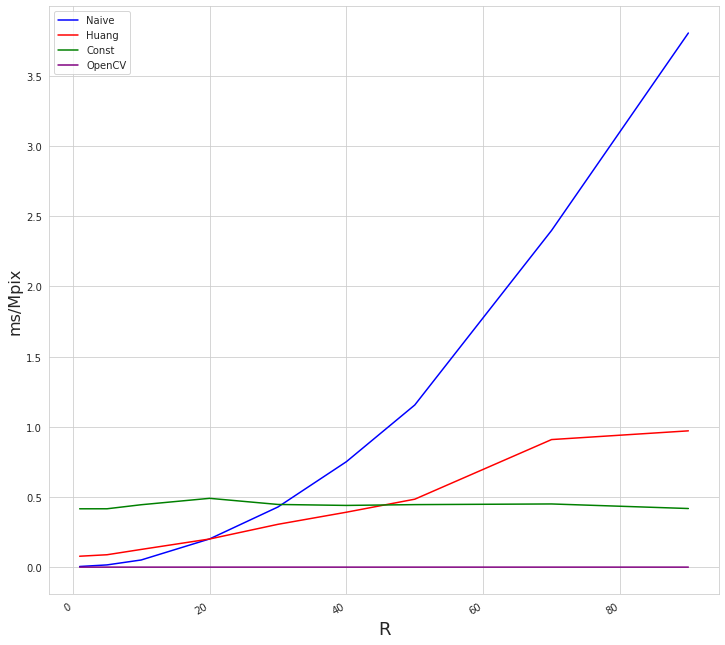

In [74]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(12,12))
x_col = 'R'
y_col = 'ms/Mpix'

ax.plot(window_sizes, naive_exec_times, color="blue", label="Naive")
ax.plot(window_sizes, huang_exec_times, color="red", label="Huang")
ax.plot(window_sizes, const_exec_times, color="green", label="Const")
ax.plot(window_sizes, open_cv_exec_times, color="purple", label="OpenCV")

ax.legend()

plt.xlabel(x_col, fontsize=18)
plt.ylabel(y_col, fontsize=16)

plt.gcf().autofmt_xdate()
plt.show()

**Аппроксимируем графики соответствующими функциями от R**

Построим график времени работы алгоритма простой сортировки от размера окна фильтра:

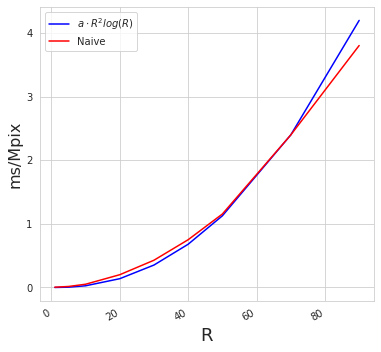

In [102]:
R = np.array(window_sizes)
a = (np.array(naive_exec_times)/(R**2*np.log(R)))[-2]

f, ax = plt.subplots(1, 1, figsize=(6,6))

ax.plot(window_sizes, a*R**2*np.log(R), color='blue', label="$a \cdot R^2 log(R)$")
ax.plot(window_sizes, naive_exec_times, color='red', label="Naive")

ax.legend()

plt.xlabel(x_col, fontsize=18)
plt.ylabel(y_col, fontsize=16)

plt.gcf().autofmt_xdate()
plt.show()

График алгоритма Huang:

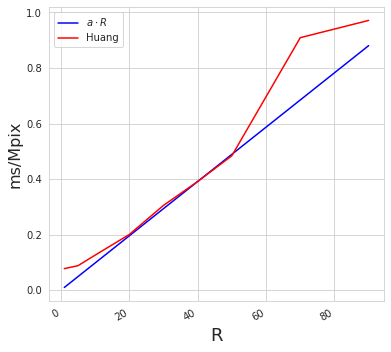

In [107]:
R = np.array(window_sizes)
a = (np.array(huang_exec_times)/(R))[-4]

f, ax = plt.subplots(1, 1, figsize=(6,6))

ax.plot(window_sizes, a*R, color='blue', label="$a \cdot R$")
ax.plot(window_sizes, huang_exec_times, color='red', label="Huang")

ax.legend()

plt.xlabel(x_col, fontsize=18)
plt.ylabel(y_col, fontsize=16)

plt.gcf().autofmt_xdate()
plt.show()

Видим, что оба алгоритма согласуются со своими теоретическими сложностями. Рассмотрим более подробно реализацию OpenCV и константного алгоритма.

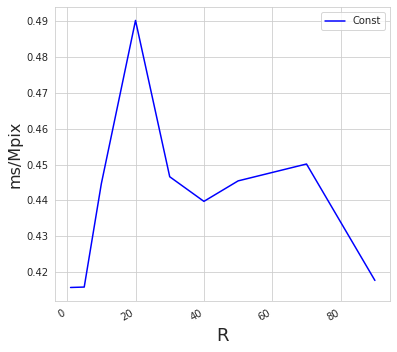

In [108]:
f, ax = plt.subplots(1, 1, figsize=(6,6))

ax.plot(window_sizes, const_exec_times, color='blue', label="Const")

ax.legend()

plt.xlabel(x_col, fontsize=18)
plt.ylabel(y_col, fontsize=16)

plt.gcf().autofmt_xdate()
plt.show()

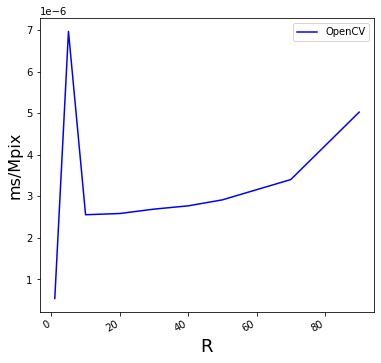

In [11]:
f, ax = plt.subplots(1, 1, figsize=(6,6))

ax.plot(window_sizes, open_cv_exec_times, color='blue', label="OpenCV")

ax.legend()

plt.xlabel(x_col, fontsize=18)
plt.ylabel(y_col, fontsize=16)

plt.gcf().autofmt_xdate()
plt.show()

# Комбинация нескольких алгоритмов в зависимости от значения R

Анализируя полученные графики можно определить наиболее оптимальный алгоритм, который будет определять в зависимости от значения R какой алгоритм применять.



*   При $R \in [0, 20]$ используется алгоритм простой сортировки
*   При $R \in (20, 45]$ используется алгоритм Huang et al.
*   При $R > 45$ используется алгоритм $O(1)$

